In [351]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
import time


<h2>Read and prepare dataset</h2>

In [299]:
# Read dataset
data_df = pd.read_csv("circles_and_squares.csv")
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [318]:
# Transform into numpy array
data = data_df.to_numpy()
data.shape

(1000, 401)

In [301]:
# Verify whether the dataset is balanced
n_square = 1*np.array([data[:, -1] == -1])
n_circle= 1*np.array([data[:, -1] == 1])

print("Quantidade de quadrados:", sum(sum(n_square)))
print("Quantidade de círculos:", sum(sum(n_circle)))

Quantidade de quadrados: 500
Quantidade de círculos: 500


In [304]:
# Prepare training dataset
Xd = data[:800, :]
X = data[:800, :-1] # Inputs
d = data[:800, -1].reshape(-1,1) # Output


# Prepare test dataset
Xd_test = data[800:, :]

X_test = data[800:, :-1] # Inputs
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test)) # Insert a columns of 1's (bias)

d_test = data[800:, -1].reshape(-1,1) # Outputs

In [305]:
# Verify whether the training dataset is balanced
n_square = 1*np.array([Xd[:, -1] == -1])
n_circle = 1*np.array([Xd[:, -1] == 1])

print("Quantidade de quadrados para treinamento:", sum(sum(n_square)))
print("Quantidade de círculos para treinamento:", sum(sum(n_circle)))

Quantidade de quadrados para treinamento: 404
Quantidade de círculos para treinamento: 396


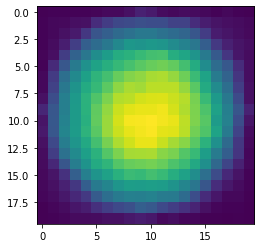

In [306]:
# Heat map of most activated pixels 
heat = np.sum(X, axis = 0).reshape((20,20))
plt.imshow(heat)

<h2>Training</h2>

In [307]:
def Rosenblatt_minibatch(x, d, eta, Nt, Ne, Nb, dw):
    """
    W = Rosenblatt_minibatch(x, d, eta, Nt, Ne, Nb)
    x: sinal de entrada
    d: sinal desejado
    eta: passo de adaptação
    Nt: número de dados de treinamento
    Ne: número de épocas
    Nb: tamanho do mini-batch
    dw: inicialização dos pesos e bias com distribuição uniforme no invervalo [-dw, dw]
    """
    ############# Same algorithm seen in class (except for output function)
    M = x.shape[1]
    Nmb = int(np.floor(Nt / Nb))
    W = np.random.uniform(-dw, dw, (Ne * Nmb + 1, M + 1))
    Xd = np.hstack((np.ones((Nt, 1)), x, d))

    eta = eta / Nb
    for k in range(Ne):
        np.random.shuffle(Xd)
        x = Xd[:, 0 : M + 1]
        d = Xd[:, [M + 1]]
        for l in range(Nmb):
            dmb = d[l * Nb : (l + 1) * Nb]
            xmb = x[l * Nb : (l + 1) * Nb, :]
            m = k*Nmb + l
            vmb = xmb @ W[[m], :].T
            ymb = np.sign(vmb) # Here we must use sign function instead of heaviside 
            emb = dmb - ymb
            W[[m + 1], :] = W[[m], :] + (eta*(xmb.T @ emb)).T

    return W

In [482]:
# Set the training parameters
eta = 50
Nt = X.shape[0]
Ne = 10000
Nb = 50
dw = 10
Nmb = int(np.floor(Nt / Nb))

print(Nmb)

16


In [483]:
# Train the model and get the weights
W = Rosenblatt_minibatch(X, d, eta, Nt, Ne, Nb, dw)
Wfinal = W[-1,:].reshape(-1,1)

<h2>Metrics</h2>

Acurácia: 70.0
Taxa de erro (coplemento): 30.0


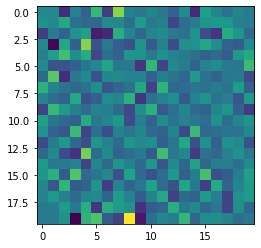

In [484]:
# Do the predicition
y = np.sign(X_test @ Wfinal).reshape(-1,1) 

# Evaluate the metrics
accuracy = accuracy_score(d_test, y)
print("Acurácia:", accuracy*100)
print("Taxa de erro (coplemento):", 100 - accuracy*100)

# Weights' heat map
heat_map_weights = Wfinal[1:].reshape((20,20))
plt.imshow(heat_map_weights)

<h2>Additional analysis</h2>

<h3>Epoch - Training time and performance improvement</h3>

In [399]:
eta = 0.5 
Nt = X.shape[0]
Nb = 40
dw = 10

start = 1000
step = 5000
stop = 100000 + step

Nes = range(start, stop, step)

In [400]:
accuracy_vector = []
time_spent = []

f = open("epoch_time_accuracy.txt", "w")
f.write(f"eta = {eta}\n")
f.write(f"Nb = {Nb}\n")
f.write(f"Nt = {X.shape[0]}\n")
f.write(f"dw = {10}\n")

for epoch in Nes:
    print("################################################")
    print(f"Training {Nes.index(epoch) + 1}")
    print(f"Training model using {epoch} epochs")

    f.write("################################################ \n")
    f.write(f"Training {Nes.index(epoch) + 1} \n")
    f.write(f"Training model using {epoch} epochs \n")

    start_time = time.time()
    W = Rosenblatt_minibatch(X, d, eta, Nt, epoch, Nb, dw)
    Wfinal = W[-1,:].reshape(-1,1)
    end_time = time.time()

    print(f" -- Training finished --")

    time_spent.append(end_time - start_time)
    f.write(f"Time spent = {end_time - start_time} \n")

    y = np.sign(X_test @ Wfinal).reshape(-1,1) 
    accuracy_i = accuracy_score(d_test, y)
    accuracy_vector.append(accuracy_i)

    f.write(f"Accuracy = {accuracy_i*100}% \n")

best_epoch_index = accuracy_vector.index(max(accuracy_vector))

print("############## Analysis finished ##############")
print(f"Best accuracy score: {max(accuracy_vector)*100}%")
print(f"Best score at training {best_epoch_index+1} with {Nes[best_epoch_index]} epochs")

f.write("############## Analysis finished ##############\n")
f.write(f"Best accuracy score: {max(accuracy_vector)*100}%\n")
f.write(f"Best score at training {best_epoch_index+1} with {Nes[best_epoch_index]} epochs\n")

f.close()

################################################
Training 1
Training model using 1000 epochs
 -- Training finished --
################################################
Training 2
Training model using 6000 epochs
 -- Training finished --
################################################
Training 3
Training model using 11000 epochs
 -- Training finished --
################################################
Training 4
Training model using 16000 epochs
 -- Training finished --
################################################
Training 5
Training model using 21000 epochs
 -- Training finished --
################################################
Training 6
Training model using 26000 epochs
 -- Training finished --
################################################
Training 7
Training model using 31000 epochs
 -- Training finished --
################################################
Training 8
Training model using 36000 epochs
 -- Training finished --
################################################
T

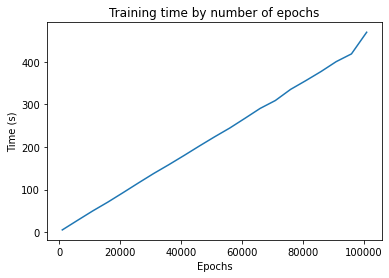

In [407]:
plt.plot(Nes, time_spent)
plt.xlabel("Epochs")
plt.ylabel("Time (s)")
plt.title("Training time by number of epochs")
plt.show()

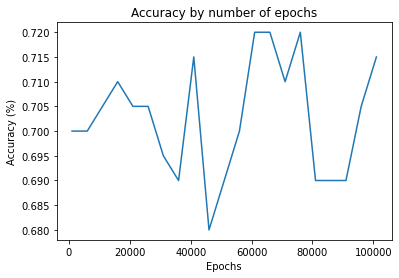

In [408]:
plt.plot(Nes, accuracy_vector)
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy by number of epochs")
plt.show()

<h3>Batch - Training time and performance improvement</h3>

In [426]:
eta = 0.5 
Nt = X.shape[0]
Ne = 5000
dw = 10

start = 10
step = 50
stop = Nt + step

Nbs = np.clip(range(start, stop, step), 1, Nt).tolist()

In [425]:
accuracy_vector_nb = []
time_spent_nb = []

f = open("batch_time_accuracy.txt", "w")
f.write(f"eta = {eta}\n")
f.write(f"Ne = {Ne}\n")
f.write(f"Nt = {X.shape[0]}\n")
f.write(f"dw = {10}\n")

for Nb in Nbs:
    print("################################################")
    print(f"Training {Nbs.index(Nb) + 1}")
    print(f"Training model using {Nb} batches")

    f.write("################################################ \n")
    f.write(f"Training {Nbs.index(Nb) + 1} \n")
    f.write(f"Training model using {Nb} batches \n")

    start_time = time.time()
    W = Rosenblatt_minibatch(X, d, eta, Nt, Ne, Nb, dw)
    Wfinal = W[-1,:].reshape(-1,1)
    end_time = time.time()

    print(f" -- Training finished --")

    time_spent_nb.append(end_time - start_time)
    f.write(f"Time spent = {end_time - start_time} \n")

    y = np.sign(X_test @ Wfinal).reshape(-1,1) 
    accuracy_i = accuracy_score(d_test, y)
    accuracy_vector_nb.append(accuracy_i)

    f.write(f"Accuracy = {accuracy_i*100}% \n")

best_batch_index = accuracy_vector_nb.index(max(accuracy_vector_nb))

print("############## Analysis finished ##############")
print(f"Best accuracy score: {max(accuracy_vector_nb)*100}%")
print(f"Best score at training {best_batch_index + 1} with {Nbs[best_batch_index]} batches")

f.write("############## Analysis finished ##############\n")
f.write(f"Best accuracy score: {max(accuracy_vector)*100}%\n")
f.write(f"Best score at training {best_batch_index + 1} with {Nbs[best_batch_index]} batches\n")

f.close()

################################################
Training 1
Training model using 10 batches
 -- Training finished --
################################################
Training 2
Training model using 60 batches
 -- Training finished --
################################################
Training 3
Training model using 110 batches
 -- Training finished --
################################################
Training 4
Training model using 160 batches
 -- Training finished --
################################################
Training 5
Training model using 210 batches
 -- Training finished --
################################################
Training 6
Training model using 260 batches
 -- Training finished --
################################################
Training 7
Training model using 310 batches
 -- Training finished --
################################################
Training 8
Training model using 360 batches
 -- Training finished --
################################################
Training 

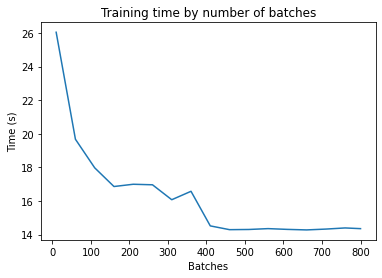

In [427]:
plt.plot(Nbs, time_spent_nb)
plt.xlabel("Batches")
plt.ylabel("Time (s)")
plt.title("Training time by number of batches")
plt.show()

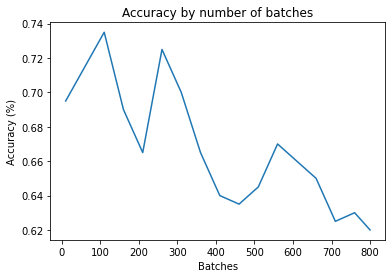

In [428]:
plt.plot(Nbs, accuracy_vector_nb)
plt.xlabel("Batches")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy by number of batches")
plt.show()

<h2>Doing a small Grid Search</h2>

In [475]:
eta = 0.5 
Nt = X.shape[0]
dw = 10

Nes = [1000, 2000, 3000, 5000, 10000]
Nbs = [50, 100, 150, 200, 300]

In [476]:
accuracy_vector_grid = []

for Ne in Nes:
    for Nb in Nbs:
        eta = Nb
        W = Rosenblatt_minibatch(X, d, eta, Nt, Ne, Nb, dw)
        Wfinal = W[-1,:].reshape(-1,1)

        y = np.sign(X_test @ Wfinal).reshape(-1,1) 
        accuracy_i = accuracy_score(d_test, y)
        accuracy_vector_grid.append(accuracy_i)

        print(f"Accuracy for {Ne} epochs and {Nb} batches = {accuracy_i*100}%")

best_batch_index = accuracy_vector_grid.index(max(accuracy_vector_grid)) % len(Nbs)
best_epoch_index = int(np.floor(accuracy_vector_grid.index(max(accuracy_vector_grid))/len(Nbs)))

print("############## Analysis finished ##############")
print(f"Best accuracy score: {max(accuracy_vector_grid)*100}%")
print(f"Best score parameters was {Nbs[best_batch_index]} batches with {Nes[best_epoch_index]} epochs")

Accuracy for 1000 epochs and 50 batches = 69.0%
Accuracy for 1000 epochs and 100 batches = 65.5%
Accuracy for 1000 epochs and 150 batches = 65.5%
Accuracy for 1000 epochs and 200 batches = 63.5%
Accuracy for 1000 epochs and 300 batches = 70.5%
Accuracy for 2000 epochs and 50 batches = 70.0%
Accuracy for 2000 epochs and 100 batches = 69.0%
Accuracy for 2000 epochs and 150 batches = 69.0%
Accuracy for 2000 epochs and 200 batches = 68.0%
Accuracy for 2000 epochs and 300 batches = 65.0%
Accuracy for 3000 epochs and 50 batches = 70.5%
Accuracy for 3000 epochs and 100 batches = 70.0%
Accuracy for 3000 epochs and 150 batches = 70.0%
Accuracy for 3000 epochs and 200 batches = 70.0%
Accuracy for 3000 epochs and 300 batches = 67.5%
Accuracy for 5000 epochs and 50 batches = 70.0%
Accuracy for 5000 epochs and 100 batches = 70.5%
Accuracy for 5000 epochs and 150 batches = 70.5%
Accuracy for 5000 epochs and 200 batches = 70.0%
Accuracy for 5000 epochs and 300 batches = 68.0%
Accuracy for 10000 epoch